# Essai avec une approche bootstrap & visualisation de l'évolution de la statistique et de la p-value en fonction de la taille de l'échantillon

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import chisquare , distributions, power_divergence
import random

## Importation, analyse et nettoyage des données

In [2]:
data = pd.read_csv("1512006-Calbicans-QUANTI_raw_abundance.csv", sep=",", header=None)
print(data.shape)
data.head(3)

(2356, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,9.325899e+04,2.765206e+04,6.973654e+04,6.309967e+04,2.252522e+04,5.307728e+04,9.088306e+04,2.035561e+04,0.000000e+00,0.000000e+00,1.021926e+05,1.794098e+05
1,5.042612e+07,1.592204e+07,4.388571e+07,1.824970e+07,1.596605e+07,1.566419e+07,2.563818e+07,2.666071e+07,1.431299e+07,2.617207e+07,2.847710e+07,4.051467e+07
2,0.000000e+00,0.000000e+00,6.015709e+03,2.413695e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.132027e+03,4.891291e+04,2.974154e+04,4.261914e+04


In [3]:
# données dans un array d'une dimmenssion
exp_numbers = data.values.reshape(data.shape[0]*data.shape[1])
print(exp_numbers.shape)

(28272,)


In [4]:
# Remove 0
exp_numbers = exp_numbers[ exp_numbers > 0 ]
exp_numbers.shape

(26936,)

## loi de Benford
fréquence de la loi de benford

In [5]:
freq_benford = np.zeros(9, dtype=float)
for i in range(9):
    freq_benford[i] = (math.log((1+(1/(i+1))), 10))
print(freq_benford)
sum(freq_benford)

[0.30103    0.17609126 0.12493874 0.09691001 0.07918125 0.06694679
 0.05799195 0.05115252 0.04575749]


0.9999999999999999

## First digit

In [6]:
first_digit = np.zeros(9, dtype=int)
for a in range(0, data.shape[1]):
    for x in data[a]:
        first = int(str(x)[0])
        if first == 0:
            continue
        first_digit[first-1] += 1
print(first_digit)
print(sum(first_digit))

[7942 4691 3273 2642 2176 1885 1638 1390 1282]
26919


## Normalisation

In [7]:
first_digit_norm = np.array(first_digit /  sum(first_digit))
print(first_digit_norm)
print(sum(first_digit_norm))
print(first_digit)

[0.29503325 0.17426353 0.12158698 0.09814629 0.0808351  0.07002489
 0.06084921 0.05163639 0.04762435]
1.0
[7942 4691 3273 2642 2176 1885 1638 1390 1282]


## Barplot de la fréquence des first digit de l'abondance des protéines et de la loi de Benford

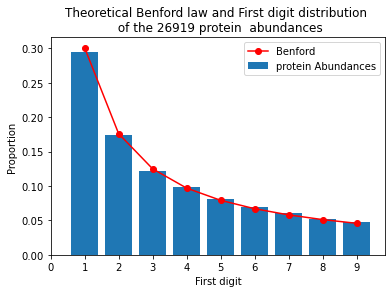

In [8]:
plt.plot(range(1,10), freq_benford, marker="o", color="red")
plt.bar(range(1,10), first_digit_norm)
plt.xticks(ticks=range(0,10))
plt.title(label=f"Theoretical Benford law and First digit distribution \n of the {sum(first_digit)} protein  abundances")
plt.xlabel("First digit")
plt.ylabel("Proportion")
plt.legend(labels = ("Benford", "protein Abundances"));

# procédure "bootstrap"
## Fonction First digit

In [9]:
def first_digit(data):
    """ Distribution des first digit des données
    
    Fonction permettant de renvoyer la distribution des first digit d'un jeu
    de données.
    
    Parameters
    ¯¯¯¯¯¯¯¯¯¯
    data : array of int
        Array d'entiers.
    
    Returns
    ¯¯¯¯¯¯¯
    fd : array
        Distribution des first digit.
    """
    fd = np.zeros(9, dtype=int)
    for x in range(len(data)):
        first = int(str(data[x])[0])
        fd[first-1] += 1
    return fd

## Fonction de moyenne des $\chi^2$

In [10]:
def meanchi2(data_obs, freq_theo, nb_val, nb_loop, type_test):
    """ Moyenne des chi2 calculés.
    
    Fonction permettant de calculer la moyennes des chi2.
    
    parameters
    ¯¯¯¯¯¯¯¯¯¯
    data_obs : array of int
        Array d'entiers des données obsevés.
    freq_theo : array of float
        Array de float des fréquences théoriques.
    nb_val : int
        Nombre de d'individu par échantillon.
    nb_loop : int
        nombre de fois que l'on réalise la procédure de "bootstrap".
    
    Returns
    ¯¯¯¯¯¯¯
    float
        La moyenne des chi2 du "bootstrap".
    """
    sumChi2 = np.zeros(nb_loop, dtype=float)
    d_theo = np.array(freq_theo * nb_val)
    for i in range(nb_loop):
        ech = np.random.choice(data_obs, size=nb_val, replace=False)
        d_obs = first_digit(ech)
        sumChi2[i] = power_divergence(f_obs=d_obs, f_exp=d_theo, lambda_=type_test)[0]
    return (sum(sumChi2) / nb_loop)

## Fonction principale de la procédure "bootstrap"

In [11]:
def bootstrap_chi2(data_obs, freq_theo, nb_val, nb_loop, type_test):
    """ Moyenne des chi2 calculés et sa p-value associé."¶
    
    Fonction permettant de calculer la moyenne des chi2 et sa p-value associé.
    
    parameters
    ¯¯¯¯¯¯¯¯¯¯
    data_obs : array of int
        Array d'entiers des données obsevés.
    freq_theo : array of float
        Array de float des fréquences théoriques.
    nb_val : int
        Nombre de d'individu par échantillon.
    nb_loop : int
        nombre de fois que l'on réalise la procédure de "bootstrap".
    
    Returns
    ¯¯¯¯¯¯¯
    p_val : float
        p-value de mean_chi2
    mean_chi2 : float
        La moyenne des chi2 du "bootstrap". 
    """
    k = len(freq_theo+1)
    mean_chi2 = meanchi2(data_obs, freq_theo, nb_val, nb_loop, type_test)
    p_val = distributions.chi2.sf(mean_chi2, k - 1)
    return p_val, mean_chi2

In [12]:
bootstrap_chi2(exp_numbers, freq_benford, 1000, 1000, 1) #chi2

(0.3928323168587416, 8.427825723042014)

In [13]:
%%time
bootstrap_chi2(exp_numbers, freq_benford, 1000, 1000, 0) #G-test

CPU times: user 2.19 s, sys: 12.1 ms, total: 2.21 s
Wall time: 2.21 s


(0.4201501518465272, 8.137554282236737)

## conclusion

La procédure mise en place ("bootstrap") permet de montrer, por un rique alpha de 5%, que les données expérimentale d'abondances de protéines suivent ici la loi de Benford. Puisque la p-value obtenu est supérieur à 5%, on ne rejette pas l'hypothése $H_0$, donc la distribution théorique suit la loi Beford.

# Évolution de la moyenne des $\chi^2$ en fonction de la taille de l'échantillon

Cette partie va nous permettrer de déteriner et de fixer une taille d'échanitllon lors de la procédure "bootstrap", que l'on utilisera ensuite dans l'ensemble des annalyses d'existence de la loi de Benford dans des données biologiques.

In [14]:
sample_size_list = list(range(200, 1000, 100)) + list(range(1000, 5000, 500)) + list(range(5000, 25001, 1000))

In [15]:
%%time
mean_chi2_list = []
p_val_list = []
for sample_size in sample_size_list:
    p_val, mean_chi2 = bootstrap_chi2(exp_numbers, freq_benford, sample_size, 1000, 1)
    p_val_list.append(p_val)
    mean_chi2_list.append(mean_chi2)
    print(sample_size, p_val, mean_chi2)

200 0.3954491927088318 8.399505075019881
300 0.4107402070161036 8.236242945046572
400 0.40056807879449674 8.344435066133109
500 0.3942547440841966 8.412417503186624
600 0.38739414030410496 8.487052594276566
700 0.40000325315211405 8.350490575687383
800 0.3959016621697291 8.394619931673677
900 0.37639585041480755 8.608437869439834
1000 0.37705986476995046 8.601046393760578
1500 0.3601491296088801 8.791957699752519
2000 0.35761728756462047 8.821038413982143
2500 0.33798060226946797 9.051374816981102
3000 0.3057964629523641 9.449619443240818
3500 0.3165021609596079 9.314018807620018
4000 0.2609038063294325 10.059079102850742
4500 0.2681896377346345 9.955125864710077
5000 0.26206666706522114 10.042341524173386
6000 0.24380696301170596 10.311998062057201
7000 0.21765050169653602 10.72703584952866
8000 0.19036038570938366 11.204844522233923
9000 0.1562833822262173 11.887739744307343
10000 0.14729412273328765 12.088604833722098
11000 0.12404078014007239 12.661459274866878
12000 0.117222790505

In [16]:
len(exp_numbers)

26936

# Évolution de la moyenne des statistics du G-test en fonction de la taille de l'échantillon

In [17]:
%%time
mean_gstat_list = []
p_val_g_list = []
for sample_size in sample_size_list:
    p_val, mean_gstat = bootstrap_chi2(exp_numbers, freq_benford, sample_size, 1000, 0)
    p_val_g_list.append(p_val)
    mean_gstat_list.append(mean_gstat)
    print(sample_size, p_val, mean_gstat)

200 0.40321359497680714 8.316140633119911
300 0.41136185012902077 8.229682865833276
400 0.41670438479034466 8.173541900314083
500 0.4015196217276423 8.33424518065084
600 0.40253671404658703 8.323369392465727
700 0.43683907957774426 7.965585258174575
800 0.3737097551362709 8.638423063383401
900 0.3914525272710082 8.442804821090407
1000 0.3668919268798918 8.715156159816031
1500 0.3693191884948559 8.687733557947707
2000 0.351788918239887 8.888503080829214
2500 0.3386955720566845 9.042832339803626
3000 0.32971751283717193 9.151011431940574
3500 0.3032760173222544 9.482034822264403
4000 0.2827485630766129 9.753587976543864
4500 0.26419878531296065 10.011798587417648
5000 0.25251329366882613 10.181561389354894
6000 0.23473007476422322 10.451884793098708
7000 0.21287900348754116 10.806957270822872
8000 0.18977550614892041 11.215677995451578
9000 0.16354108805996959 11.73256217243997
10000 0.15115880876837917 12.001010358305475
11000 0.14554096359458826 12.128986105813658
12000 0.1134091326283

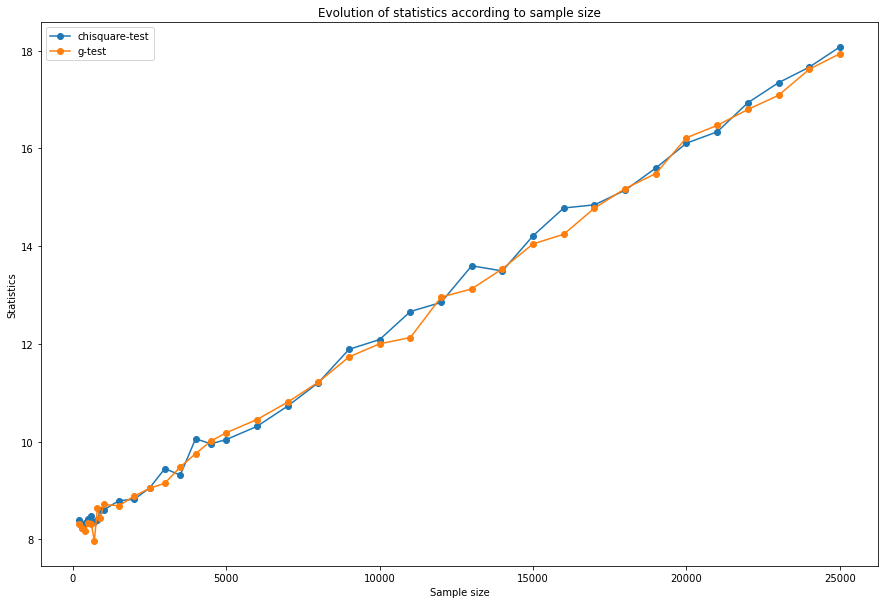

In [18]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, mean_chi2_list, marker='o')
plt.plot(sample_size_list, mean_gstat_list, marker='o')
plt.title("Evolution of statistics according to sample size")
plt.ylabel("Statistics")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

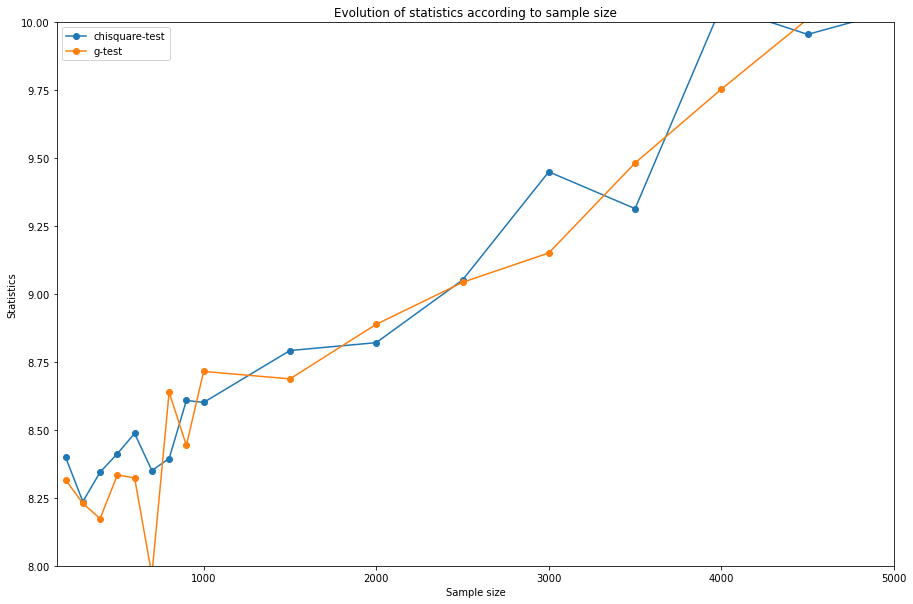

In [19]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, mean_chi2_list, marker='o')
plt.plot(sample_size_list, mean_gstat_list, marker='o')
plt.xlim(left=150, right=5000)
plt.ylim(bottom=8, top=10)
plt.title("Evolution of statistics according to sample size")
plt.ylabel("Statistics")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

In [20]:
mean_chi2_list_log = np.log10(np.array(mean_chi2_list))
mean_gstat_list_log = np.log10(np.array(mean_gstat_list))
sample_size_log = np.log10(np.array(sample_size_list))
"""
print(mean_chi2_list_log)
print(mean_gstat_list_log)
print(sample_size_log)
""";

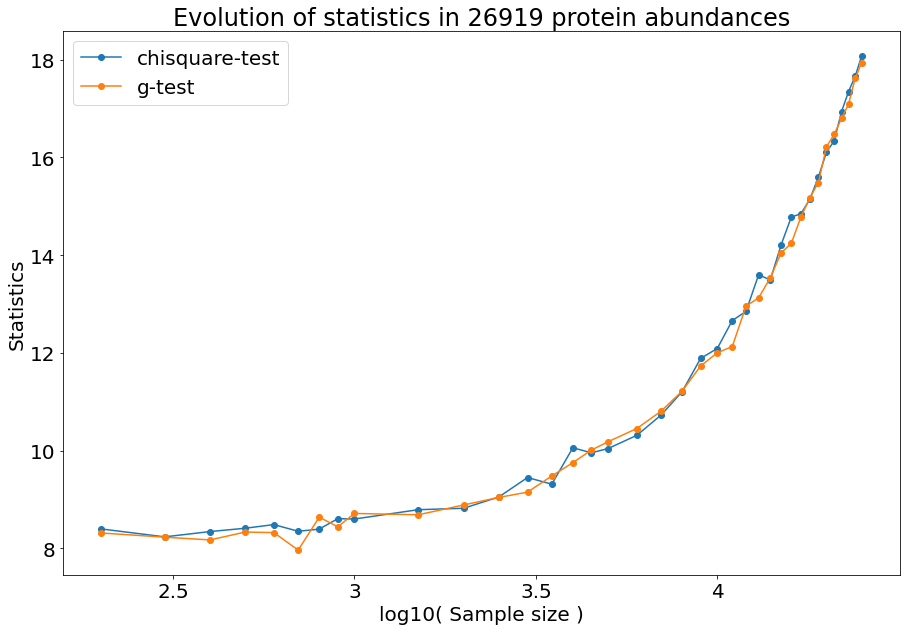

In [45]:
plt.figure(figsize=(15,10))
plt.rc('font', size=20);
plt.plot(sample_size_log, mean_chi2_list, marker='o')
plt.plot(sample_size_log, mean_gstat_list, marker='o')
plt.title("Evolution of statistics in 26919 protein abundances")
plt.ylabel("Statistics")
plt.xlabel("log10( Sample size )")
plt.xticks(ticks=[2.5,3,3.5,4],labels=["2.5","3","3.5","4"])
plt.legend(labels=("chisquare-test", "g-test"));
plt.savefig("abundance_statistics_evolution.png",transparent=True)

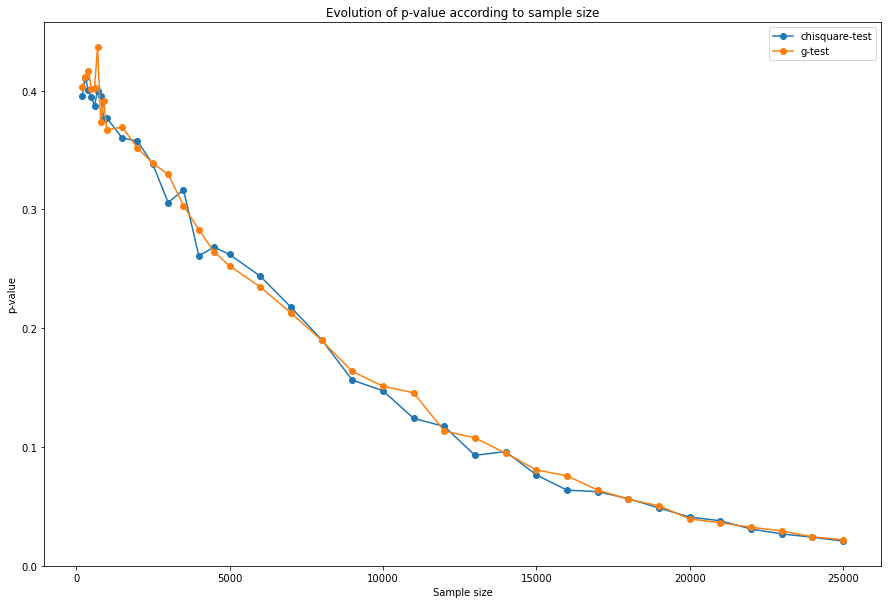

In [22]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, p_val_list, marker='o')
plt.plot(sample_size_list, p_val_g_list, marker='o')
plt.title("Evolution of p-value according to sample size")
plt.ylabel("p-value")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

In [23]:
p_val_list_log = -np.log10(np.array(p_val_list))
p_val_g_list_log = -np.log10(np.array(p_val_g_list))
"""
print(p_val_list_log)
print(p_val_g_list_log)
""";

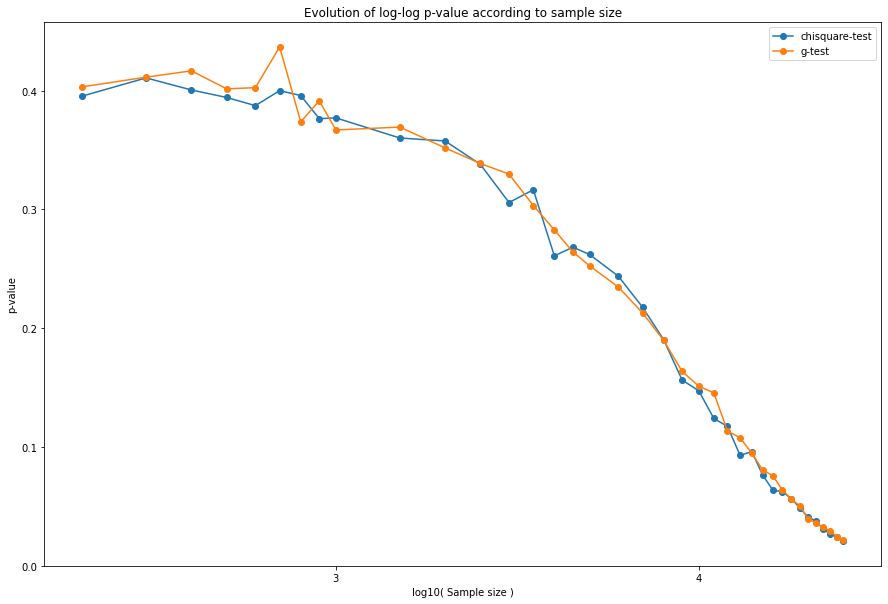

In [24]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_log, p_val_list, marker='o')
plt.plot(sample_size_log, p_val_g_list, marker='o')
plt.title("Evolution of log-log p-value according to sample size")
plt.ylabel("p-value")
plt.xlabel("log10( Sample size )")
plt.xticks(ticks=[3,4],labels=["3","4"])
plt.legend(labels=("chisquare-test", "g-test"));

## Evolution de la satistique avec la taille des protéines dans Uniprot/SwissProt

In [25]:
import sys, os

In [26]:
sys.path.insert(0, '../Prot_tot_uniprot/')

In [27]:
data2 = pd.read_csv("../Prot_tot_uniprot/uniprot-reviewed yes.tab", sep = "\t", index_col=0)

In [28]:
data2.head

<bound method NDFrame.head of         Length
Entry         
Q8K9I1     960
Q664P8     255
Q66K14    1250
Q8E4B4     239
B3CQ06     426
...        ...
C3L855     410
P41413    1809
B7HED5     394
B1IUE0     408
Q1KXU1      31

[564638 rows x 1 columns]>

In [29]:
data2.describe()

,Length
count,564638.000000
mean,360.442643
std,336.460236
min,2.000000
25%,169.000000
50%,294.000000
75%,449.000000
max,35213.000000


In [30]:
length_prot = list(data2["Length"])

In [31]:
sample_size_list = list(range(200, 1000, 100)) + list(range(1000, 5000, 500)) + list(range(5000, 25001, 1000))

In [32]:
%%time
mean_chi2_list2 = []
p_val_list2 = []
for sample_size in sample_size_list:
    p_val, mean_chi2 = bootstrap_chi2(length_prot, freq_benford, sample_size, 1000, 1)
    p_val_list2.append(p_val)
    mean_chi2_list2.append(mean_chi2)
    print(sample_size, p_val, mean_chi2)

200 0.008210975507383894 20.625730262572862
300 0.0006380548431744224 27.257736679943097
400 4.644617264529312e-05 33.67884083513103
500 3.1301169417666066e-06 40.054183458430295
600 1.530277015042184e-07 47.004618654849374
700 9.795273012655645e-09 53.21587911802788
800 3.2252953829860424e-10 60.814575729466256
900 1.7659085540545533e-11 67.20464885215088
1000 6.369091313564067e-13 74.4455426402902
1500 1.7638702873734867e-19 106.75759243520686
2000 4.870316759692811e-26 138.49809544122235
2500 3.5324341370401915e-33 172.68286487792196
3000 6.7745134390269134e-40 204.62404152198457
3500 6.532183705961718e-47 237.82704168937286
4000 1.2393557210812405e-53 269.5271340569289
4500 2.2822551598255886e-60 301.20418188704843
5000 5.300980441424451e-68 337.0301305575543
6000 4.4732682885108363e-82 402.90741206018293
7000 1.7383950934084288e-96 470.19243878975584
8000 1.498437738703528e-110 535.7418269389432
9000 4.635797503432339e-124 598.6189151184363
10000 1.41918393066175e-138 666.09757893

In [33]:
%%time
mean_gstat_list2 = []
p_val_g_list2 = []
for sample_size in sample_size_list:
    p_val, mean_gstat = bootstrap_chi2(length_prot, freq_benford, sample_size, 1000, 0)
    p_val_g_list2.append(p_val)
    mean_gstat_list2.append(mean_gstat)
    print(sample_size, p_val, mean_gstat)

200 0.00850213212586068 20.531386932992916
300 0.0006461899020907323 27.225937944167228
400 5.680249410908673e-05 33.194869647277
500 2.951323699319199e-06 40.19124879220556
600 2.5032974924885514e-07 45.88170312923901
700 1.3630732204389133e-08 52.47409611038134
800 8.518817697050518e-10 58.663446521037514
900 5.0717428573896825e-11 64.89094601874287
1000 2.5323734687953514e-12 71.4450784865196
1500 8.70770019512836e-19 103.3747414258934
2000 1.6484576747899067e-25 135.94978375136367
2500 2.1163808298738e-32 168.9735079544543
3000 1.0965353766740458e-38 198.8868019652187
3500 1.3965271458956818e-45 231.54291689788286
4000 2.7105041109854726e-52 263.21578390664706
4500 7.4903749477188e-59 294.0794430713732
5000 1.3935800198773946e-65 325.6824016075767
6000 3.67323834570848e-79 389.2806023814255
7000 3.2163009238185916e-93 454.94951418786997
8000 1.6140031586639659e-106 516.9592440938106
9000 9.47862104260148e-120 578.5640143897965
10000 2.576391342168211e-134 646.3038375181886
11000 1.

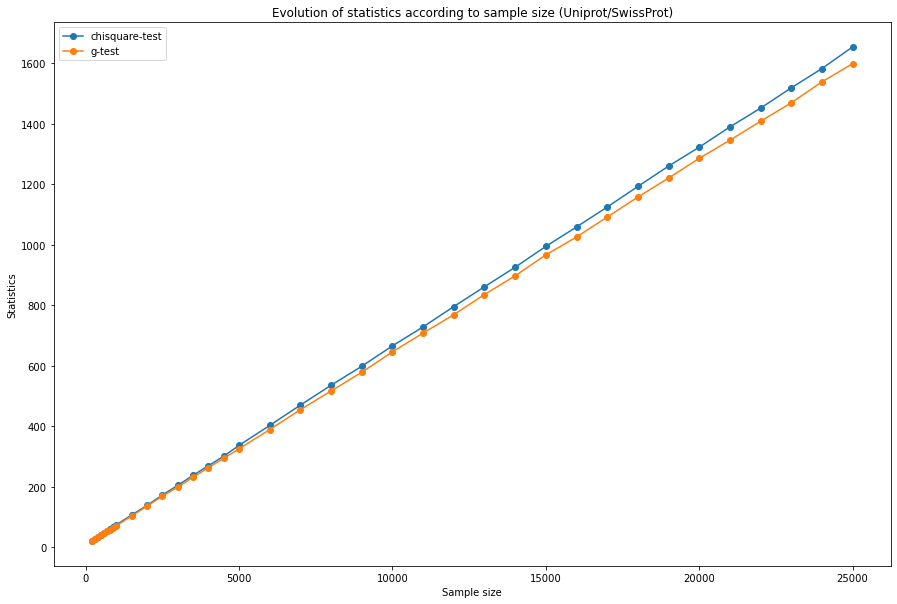

In [35]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, mean_chi2_list2, marker='o')
plt.plot(sample_size_list, mean_gstat_list2, marker='o')
plt.title("Evolution of statistics according to sample size (Uniprot/SwissProt)")
plt.ylabel("Statistics")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

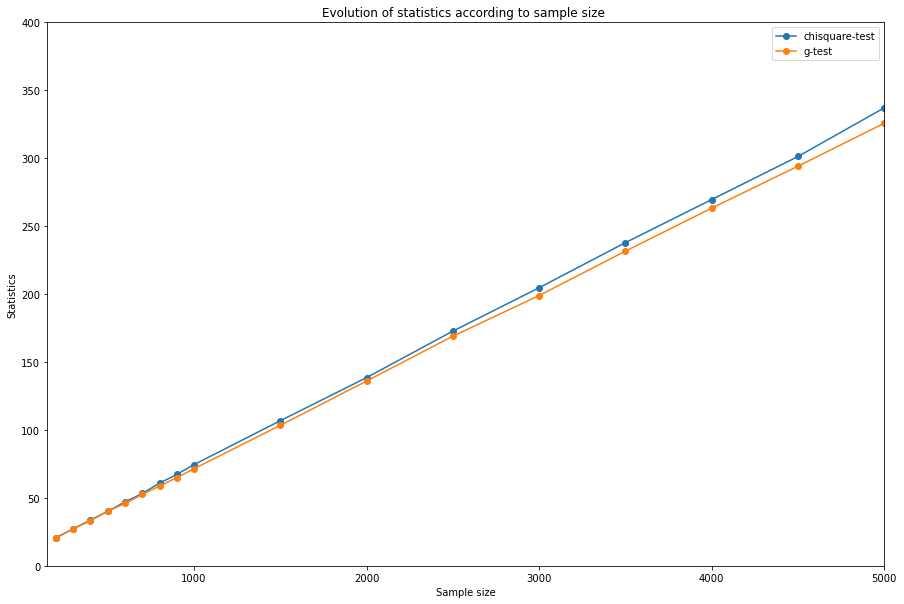

In [36]:
plt.figure(figsize=(15,10))
plt.plot(sample_size_list, mean_chi2_list2, marker='o')
plt.plot(sample_size_list, mean_gstat_list2, marker='o')
plt.xlim(left=150, right=5000)
plt.ylim(bottom=0, top=400)
plt.title("Evolution of statistics according to sample size ")
plt.ylabel("Statistics")
plt.xlabel("Sample size")
plt.legend(labels=("chisquare-test", "g-test"));

In [38]:
mean_chi2_list_log = np.log10(np.array(mean_chi2_list2))
mean_gstat_list_log = np.log10(np.array(mean_gstat_list2))
sample_size_log = np.log10(np.array(sample_size_list))
"""
print(mean_chi2_list_log)
print(mean_gstat_list_log)
print(sample_size_log)
""";

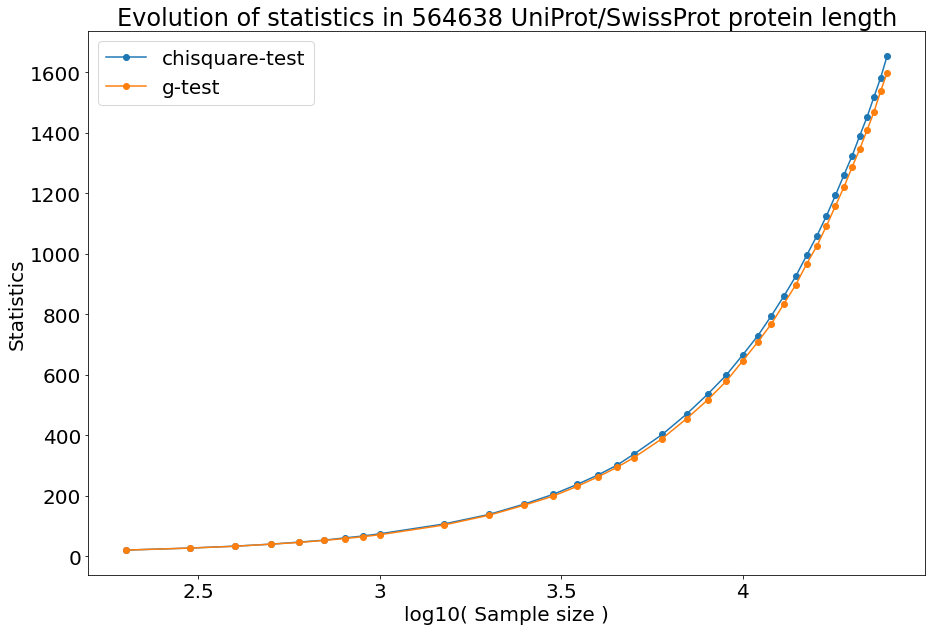

In [44]:
plt.figure(figsize=(15,10))
plt.rc('font', size=20);
plt.plot(sample_size_log, mean_chi2_list2, marker='o')
plt.plot(sample_size_log, mean_gstat_list2, marker='o')
plt.title(f"Evolution of statistics in {len(length_prot)} UniProt/SwissProt protein length")
plt.ylabel("Statistics")
plt.xlabel("log10( Sample size )")
plt.xticks(ticks=[2.5,3,3.5,4],labels=["2.5","3","3.5","4"])
plt.legend(labels=("chisquare-test", "g-test"));
plt.savefig("SwiisProt_statistics_evolution.png",transparent=True)